# Introduction to OpenAI Responses API: Building a Research Assistant

## Overview
In this notebook, we'll explore the OpenAI Responses API by building a practical research assistant that can help analyze academic papers and generate research summaries. The Responses API is the modern replacement for the deprecated Assistants API, offering improved performance and a simpler, more intuitive interface.

The Responses API allows us to create AI-powered responses with specific instructions, capabilities, and access to various tools. In this lesson, we'll learn about:
- Creating responses with custom instructions
- Managing persistent conversations
- Handling streaming responses
- Working with built-in tools like Code Interpreter
- Understanding the migration from Assistants to Responses API

## Key Concept Changes from Assistants API

If you're familiar with the Assistants API, here are the main changes:
- **Assistants → Instructions**: No more persistent assistant objects. Instructions are passed with each request.
- **Threads → Conversations**: Use `previous_response_id` to link responses together.
- **Runs → Responses**: Direct, synchronous execution instead of async polling.
- **Run Steps → Items**: Simplified streaming events.

## Setup and Dependencies

In [ ]:
%pip install openai==2.6.1

In [50]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [51]:
from openai import OpenAI
import json

# Initialize the OpenAI client
client = OpenAI()

## What is the Responses API?

The Responses API is OpenAI's modern approach to building conversational AI applications. It provides a streamlined way to create AI-powered responses with persistent conversation management and tool integration.

### Key Features:
1. **Stateless Instructions**:
   - Define how the AI behaves by passing instructions with each request.
   - No need to create and manage persistent assistant objects.

2. **Tool Integration**:
   - Leverage built-in tools such as:
     - **Code Interpreter**: Execute and debug Python code.
     - **File Search**: Search through uploaded documents.
     - **Web Search**: Access real-time information from the internet.

3. **Persistent Conversations**:
   - Link responses together using `previous_response_id`.
   - Automatically manage conversation context.
   - Responses are stored for 30 days by default.

4. **Performance Benefits**:
   - 40-80% improvement over previous APIs through enhanced caching.
   - Synchronous execution for simpler code.
   - Real-time streaming support.

### Core Concepts:
- **Response**: A single AI-generated reply with a unique ID
- **Conversation**: A chain of linked responses using `previous_response_id`
- **Instructions**: System-level guidance for AI behavior (must be included with each request)
- **Input**: The user's message or query
- **Tools**: Built-in capabilities like code execution and file search

## Creating Our First Response

Let's create a simple response with research-focused instructions:

In [61]:
# Define instructions for our research assistant
research_instructions = """You are a research assistant specialized in analyzing academic papers and research data.
Your tasks include:
- Summarizing research findings
- Analyzing statistical data
- Creating visualizations of research results
- Providing critical analysis of methodologies
Always maintain academic rigor and cite specific sections when referring to source materials."""

# Create our first response
response = client.responses.create(
    model="gpt-4o",
    instructions=research_instructions,
    input="Hello! I'd like help analyzing some research data. Can you help?"
)

print(f"Response ID: {response.id}")
print(f"\nAssistant: {response.output_text}")

Response ID: resp_073c5571c2f441d3006900e434d6108193ab924e3070aac36b

Assistant: Of course! Please provide the research data or details about the study, and I'll be happy to assist with the analysis.


## Managing Persistent Conversations

To continue a conversation, we use the `previous_response_id` parameter. This automatically loads the conversation history:

In [62]:
# Save the response ID for conversation continuity
last_response_id = response.id

# Continue the conversation
response2 = client.responses.create(
    model="gpt-4o",
    instructions=research_instructions,
    input="Great! I have patient recovery time data for two treatments that I'd like to compare.",
    previous_response_id=last_response_id
)

print(f"Response ID: {response2.id}")
print(f"\nAssistant: {response2.output_text}")

# Update for next turn
last_response_id = response2.id

Response ID: resp_073c5571c2f441d3006900e4527d78819381909b09045eb6d3

Assistant: Please share the data or any relevant statistics, and let me know what specific comparisons or analyses you're interested in.


## Using Tools: Code Interpreter

Let's enable the code interpreter tool to analyze statistical data. This allows the AI to execute Python code for data analysis and visualization:

In [63]:
# Create a response with code interpreter enabled
analysis_response = client.responses.create(
    model="gpt-4.1",
    instructions=research_instructions,
    input="""I have a dataset of patient recovery times after two different treatments.
Can you help me analyze the statistical significance of the results?

Treatment A: [45, 42, 39, 47, 41, 43, 40, 44, 38, 46]
Treatment B: [52, 49, 51, 47, 50, 53, 48, 51, 49, 50]""",
    tools=[
        {"type": "code_interpreter",
        "container": {"type": "auto"}}
        ],
    previous_response_id=last_response_id,
    store=True  # Store the response for 30 days
)

print(f"Response ID: {analysis_response.id}")
print(f"\nAssistant: {analysis_response.output_text}")

# Update for next turn
last_response_id = analysis_response.id

Response ID: resp_073c5571c2f441d3006900e48317c0819388fd1ee8bb4fb3c9

Assistant: Absolutely! Here’s how I’ll proceed:

1. **Descriptive Statistics**: Calculate mean and standard deviation for each treatment.
2. **Statistical Test**: Since you have two independent groups, a two-sample t-test will determine if the difference is statistically significant.
3. **Interpretation**: I’ll explain the results and their implications.

Let’s get started:

### 1. Descriptive Statistics

Let’s calculate the mean and standard deviation for each group.

### 2. Two-Sample t-test

Assumptions:
- Independent samples
- Normally distributed populations (approximate, given sample size)
- Equal or unequal variance test (to be checked)

Let's run these analyses.Here are the statistical results of the comparison:

### Descriptive Statistics
- **Treatment A**: Mean = 42.5 days, Standard Deviation ≈ 3.03
- **Treatment B**: Mean = 50.0 days, Standard Deviation ≈ 1.83

### Inferential Statistics
- **Welch’s t-test

## Streaming Responses

For a better user experience, we can stream responses in real-time. Let's implement a streaming handler:

In [55]:
# Create a streaming response
print("Assistant: ", end="", flush=True)

stream = client.responses.create(
    model="gpt-5-mini",
    instructions=research_instructions,
    input="""Can you create visualizations comparing the two treatments and 
perform a two-sample t-test to determine statistical significance?

Treatment A: [45, 42, 39, 47, 41, 43, 40, 44, 38, 46]
Treatment B: [52, 49, 51, 47, 50, 53, 48, 51, 49, 50]""",
    tools=[{"type": "code_interpreter",
        "container": {"type": "auto"}}],
    stream=True
)

# Process the stream
current_response_id = None
for event in stream:
    # Handle text deltas
    if event.type == "response.output_text.delta":
        print(event.delta, end="", flush=True)
    
    # Handle tool calls
    elif event.type == "response.output_item.added":
        if hasattr(event, 'item') and event.item.type == "code_interpreter":
            print("\n\n[Running code analysis...]\n", flush=True)
    
    # Capture the response ID
    elif event.type == "response.completed":
        current_response_id = event.response.id
        print(f"\n\nResponse ID: {current_response_id}")

# Update for conversation continuity
if current_response_id:
    last_response_id = current_response_id

Assistant: I created visual comparisons and ran two-sample t-tests. Findings, test details, and downloadable plots are below.

Key summary (n = 10 per group)
- Treatment A: mean = 42.5, SD = 3.028, 95% CI = (40.334, 44.666)
- Treatment B: mean = 50.0, SD = 1.826, 95% CI = (48.694, 51.306)
- Mean difference (A − B) = −7.5 (B higher)

Tests and effect size
- Levene’s test for equal variances: F = 3.582, p = 0.0746 (no strong evidence to reject equal variances at α = 0.05, though p is moderately small)
- Welch’s t-test (unequal variances): t = −6.708, df ≈ 14.78, p < 0.001
- Student’s t-test (equal variances): t = −6.708, p < 0.001 (results are the same here given the sample structure)
- 95% CI for difference (Welch): −9.886 to −5.114 (i.e., B − A ≈ +7.5, 95% CI ≈ 5.11 to 9.89)
- Cohen’s d (pooled SD) = 3.00 (very large effect)

Interpretation
- Treatment B has a substantially higher mean than Treatment A (mean difference ≈ 7.5). The difference is statistically significant (p < 0.001) and

## Advanced Streaming with Event Handling

Let's create a more sophisticated event handler for better control over streaming:

In [56]:
def handle_streaming_response(stream):
    """Process streaming response events with detailed handling."""
    response_id = None
    text_buffer = []
    
    for event in stream:
        # Text content streaming
        if event.type == "response.output_text.delta":
            print(event.delta, end="", flush=True)
            text_buffer.append(event.delta)
        
        # New item added (like code execution)
        elif event.type == "response.output_item.added":
            item_type = getattr(event.item, 'type', 'unknown')
            print(f"\n\n[Tool: {item_type}]\n", flush=True)
        
        # Code interpreter input
        elif event.type == "response.output_item.code_interpreter.input":
            print("\nCode Input:", flush=True)
            print(event.input, flush=True)
        
        # Code interpreter logs
        elif event.type == "response.output_item.code_interpreter.logs":
            print("\nCode Output:", flush=True)
            print(event.logs, flush=True)
        
        elif event.type == "response.output_item.code_interpreter_call":
            print("\nCode Output:", flush=True)
            print(event.logs, flush=True)
        
        # Response completed
        elif event.type == "response.completed":
            response_id = event.response.id
            print(f"\n\n✓ Response completed (ID: {response_id})")
    
    return response_id, ''.join(text_buffer)

# Use the handler
print("\nAssistant: ", end="", flush=True)
stream = client.responses.create(
    model="gpt-4.1",
    instructions=research_instructions,
    input="Yes save the plots as .png files in the current working directory, then display them",
    tools=[{"type": "code_interpreter",
        "container": {"type": "auto"}}],
    previous_response_id=last_response_id,
    stream=True
)

response_id, full_text = handle_streaming_response(stream)
last_response_id = response_id


Assistant: 

[Tool: message]

Here are your plots, saved as .png files in the current directory, and they will be displayed below.

**Plot 1:** Boxplot + individual points and histogram/KDE overlay  
**Plot 2:** Bar chart of means with 95% CI

Let me display both now:

[Tool: code_interpreter_call]



[Tool: message]

The above images show:

1. **Boxplot with individual points and histogram + KDE:** Visualizes the distribution and spread of both treatments.
2. **Bar chart of means with 95% confidence intervals:** Highlights the difference in means and the range of likely values.

The PNG files are saved and you can use or download them as follows:
- `treatment_comparison.png` (Boxplot + histogram overlay)
- `treatment_means_ci.png` (Means with 95% CI)

Let me know if you need any additional types of plots or want publication-style figure formatting!

✓ Response completed (ID: resp_0641f554f4c6ba8e006900b1c277f0819699510efbbe45fa61)


## Retrieving Files from Code Interpreter

When the code interpreter generates files (like plots), they're stored in a container. To download and display them, we need to:

1. Extract the container_id and file_ids from the response annotations
2. Download each file using the OpenAI API
3. Display them in the Jupyter notebook

Let's retrieve and display the plots:

Container ID: cntr_6900b13f8a408190810c1fd2540c2dd500c5b95cbd28ff0a
Found 2 files

cfile_6900b1ca9ed881919536666717565e1c.png:


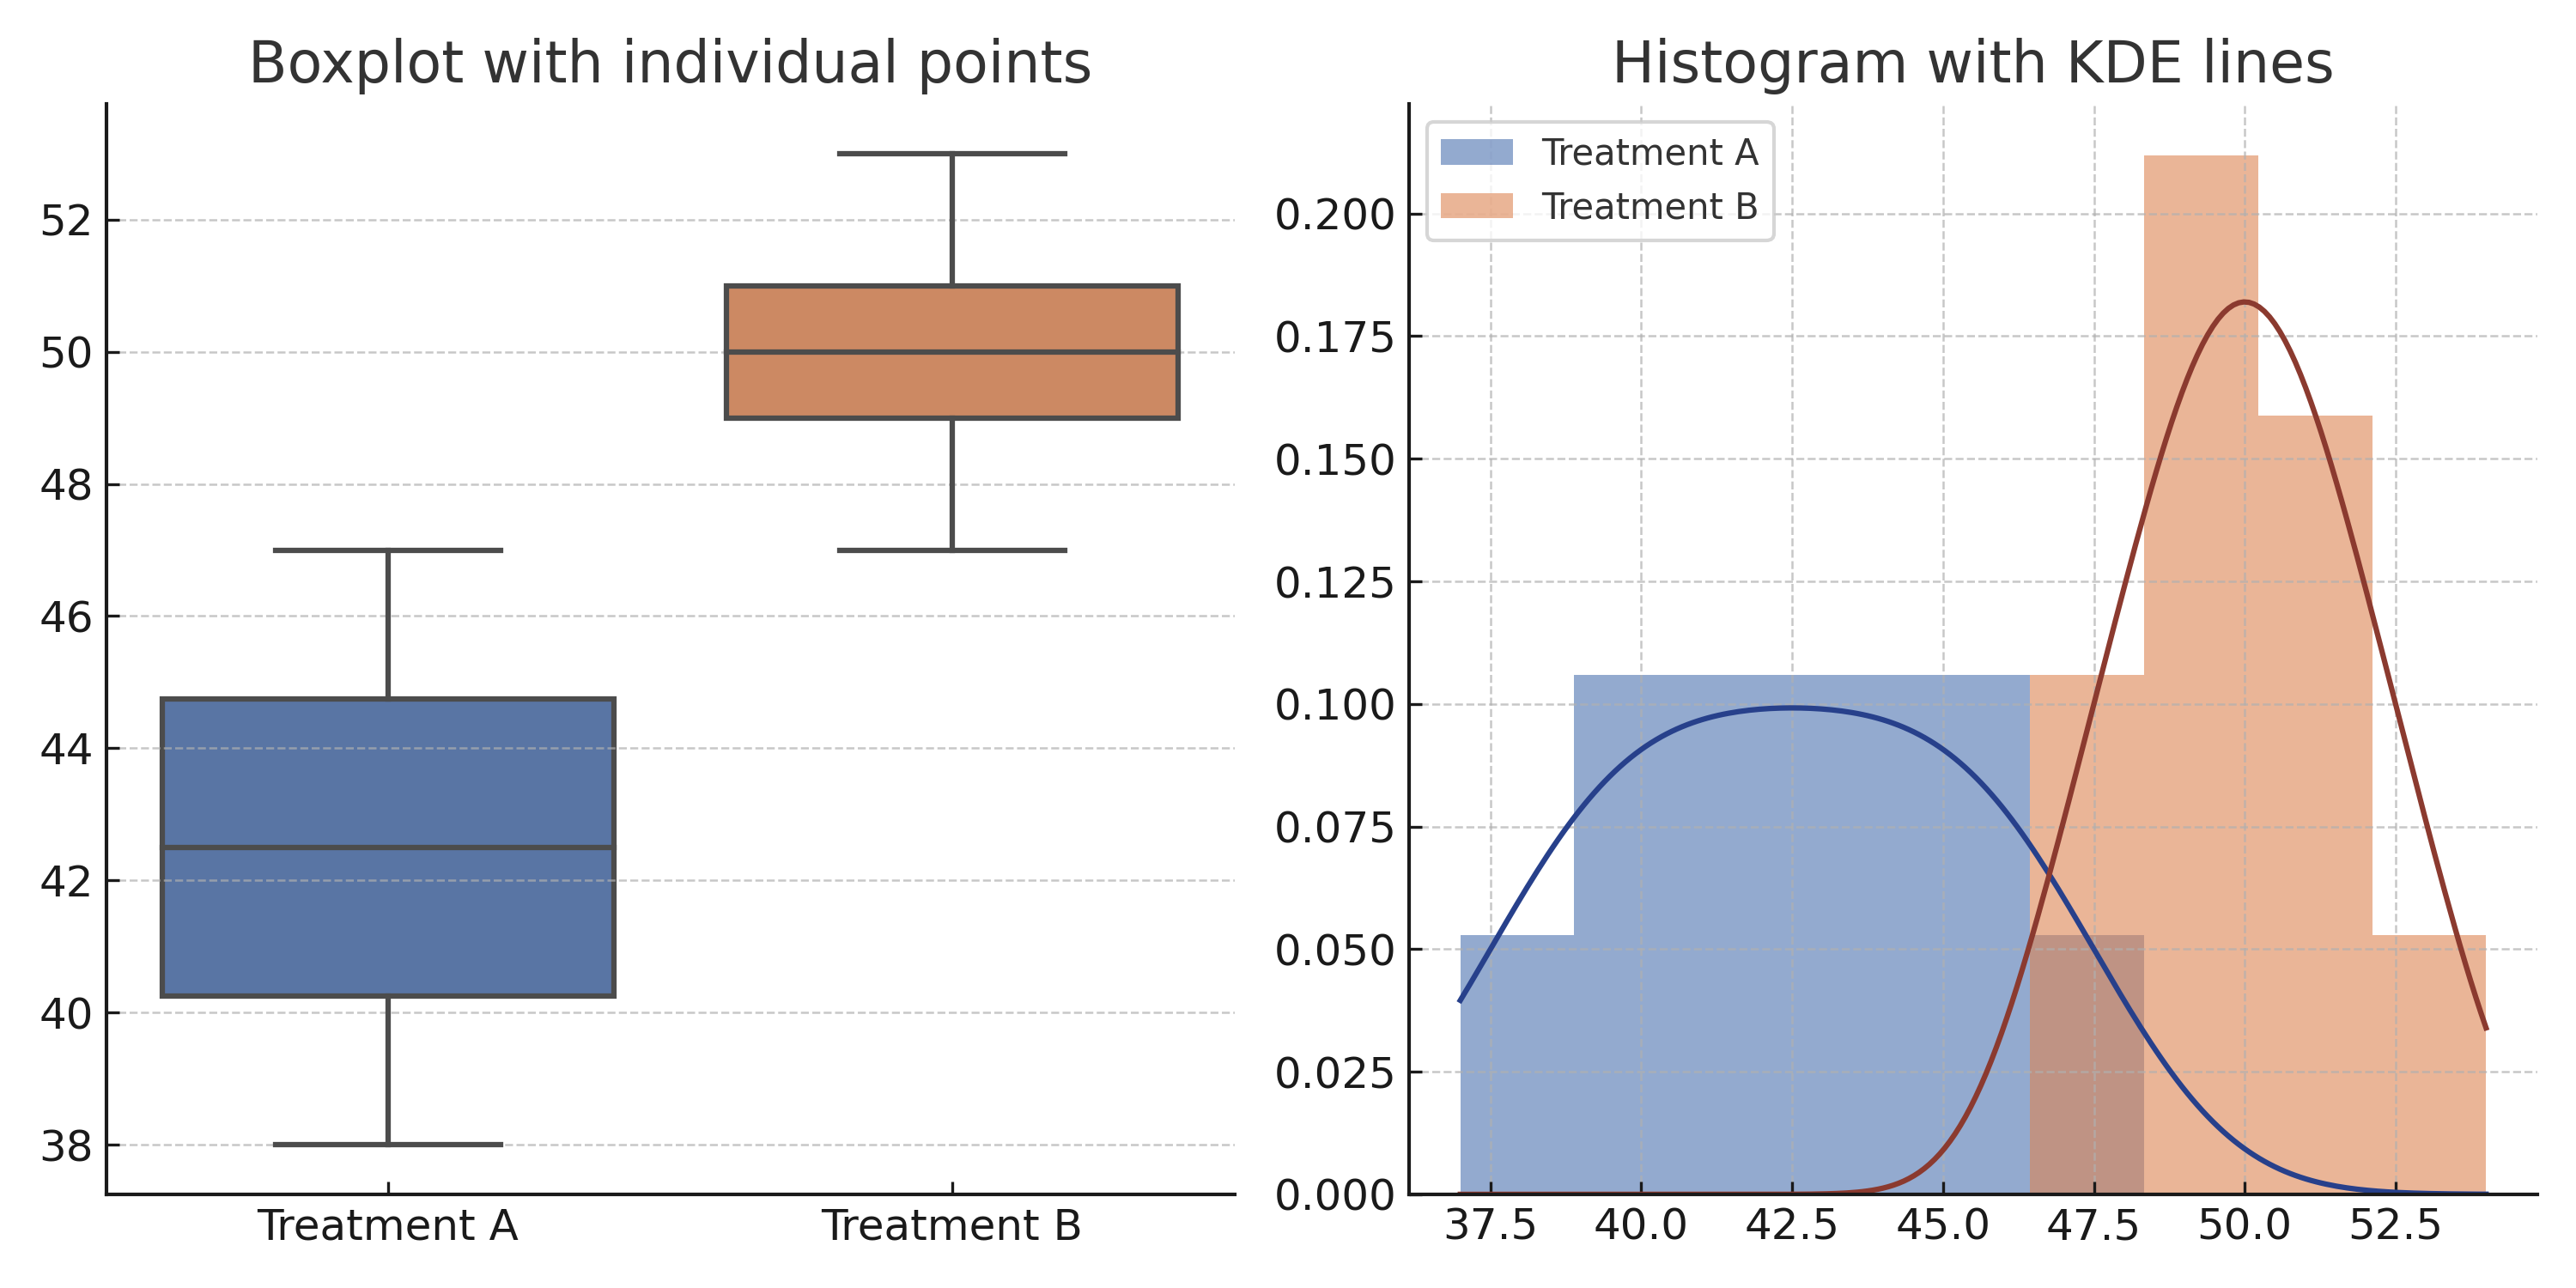


cfile_6900b1caa3c08191bef2f894c4ba1333.png:


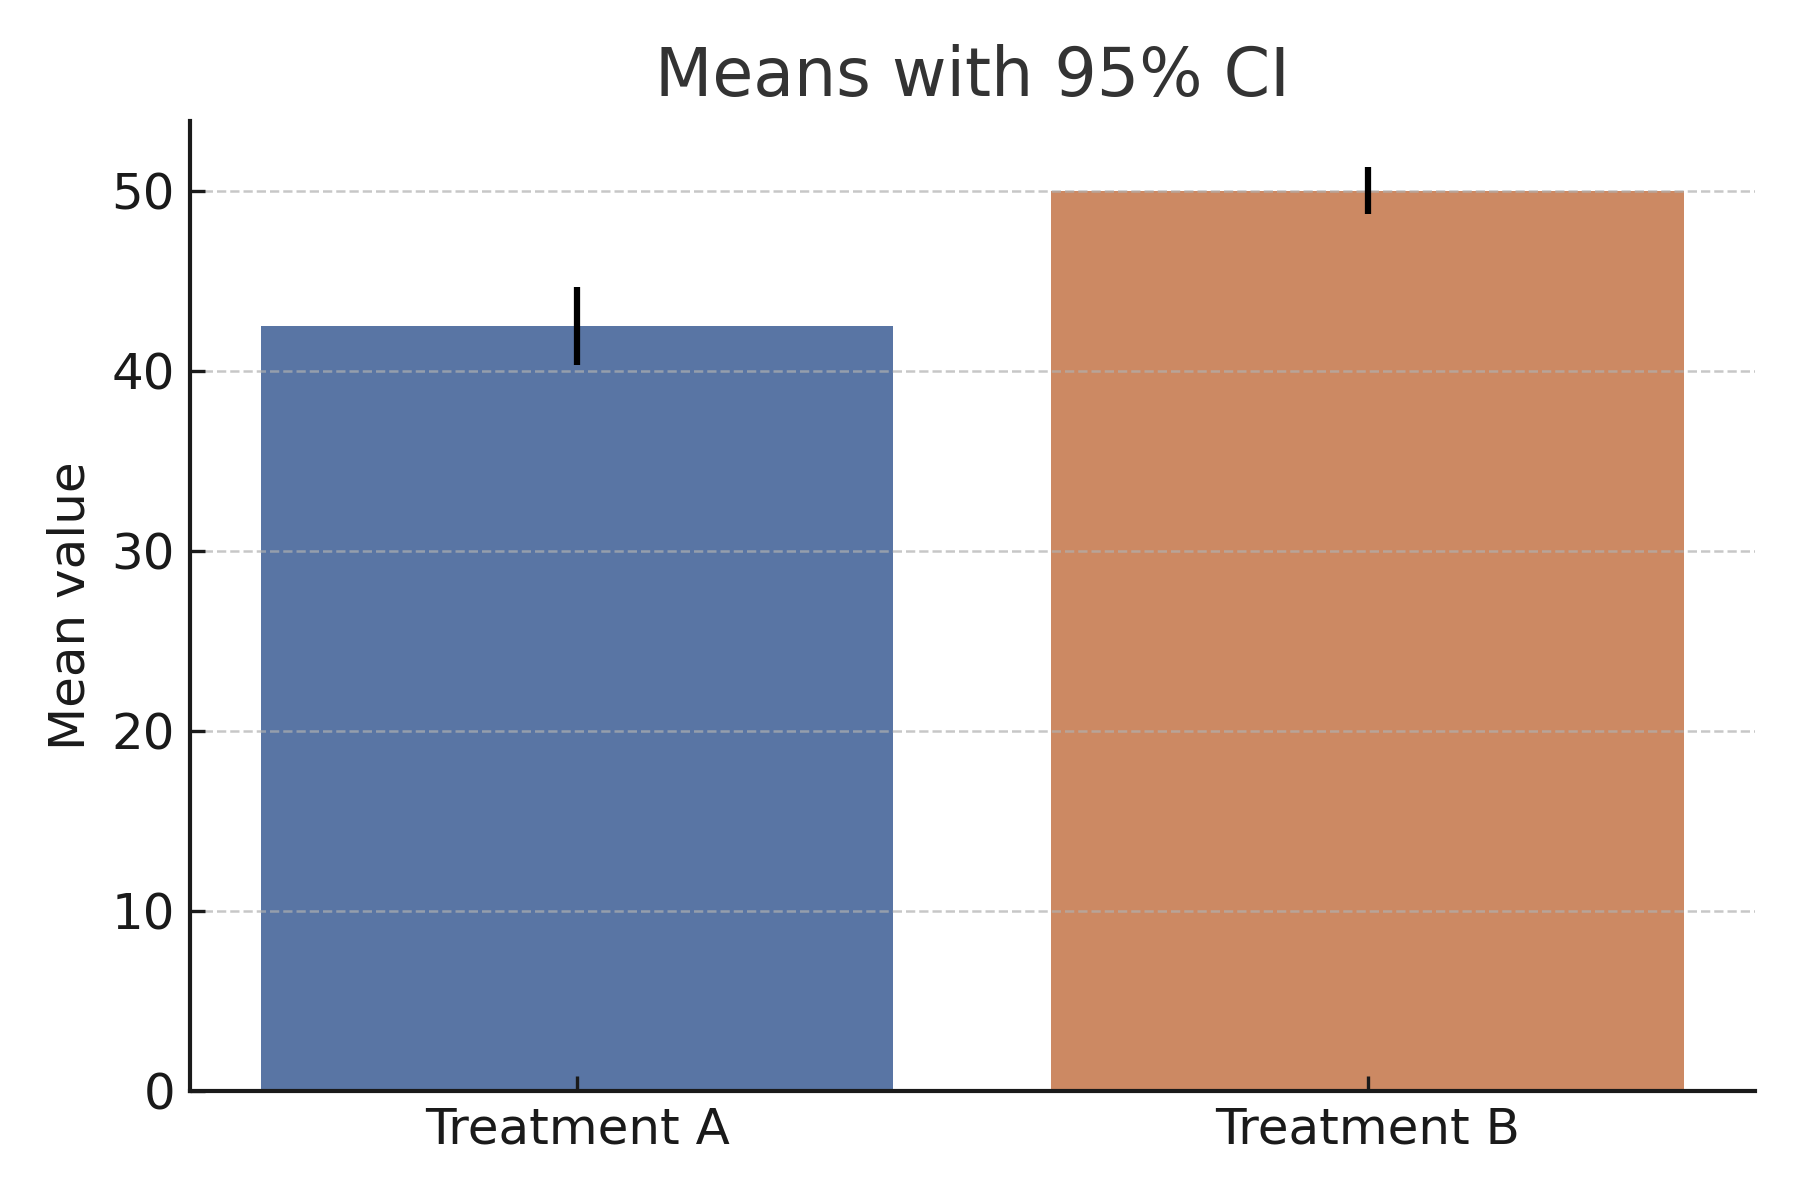

In [57]:
import requests
from IPython.display import Image, display

# Retrieve the response to get annotations
output_response = client.responses.retrieve(last_response_id)

# Extract container_id and file information from annotations
container_id = None
file_info = []

# Look through output messages for annotations
for output_item in output_response.output:
    if hasattr(output_item, 'content'):
        for content in output_item.content:
            if hasattr(content, 'annotations'):
                for annotation in content.annotations:
                    if annotation.type == 'container_file_citation':
                        container_id = annotation.container_id
                        file_info.append({
                            'file_id': annotation.file_id,
                            'filename': annotation.filename
                        })

print(f"Container ID: {container_id}")
print(f"Found {len(file_info)} files")

# Download and display each file
if container_id and file_info:
    headers = {
        "Authorization": f"Bearer {os.environ.get('OPENAI_API_KEY')}"
    }
    
    for file in file_info:
        file_id = file['file_id']
        filename = file['filename']
        
        # Download file content
        url = f"https://api.openai.com/v1/containers/{container_id}/files/{file_id}/content"
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            print(f"\n{filename}:")
            # Display the image
            display(Image(response.content))
        else:
            print(f"Error downloading {filename}: {response.status_code}")
else:
    print("No container or files found in annotations.")

### Alternative Methods for File Retrieval

#### Using cURL to Download Files

If you prefer command-line tools, you can download files directly using cURL:

```bash
curl https://api.openai.com/v1/containers/{container_id}/files/{file_id}/content \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  --output filename.png
```

#### Listing All Files in a Container

You can also list all files in a container to see what's available:

```python
# List all files in the container
if container_id:
    response = requests.get(
        f"https://api.openai.com/v1/containers/{container_id}/files",
        headers={"Authorization": f"Bearer {os.environ.get('OPENAI_API_KEY')}"}
    )
    files_list = response.json()
    print(json.dumps(files_list, indent=2))
```

**Key Points:**
- Files are stored in containers managed by the code interpreter
- Each file has a unique `file_id` that can be extracted from response annotations
- Files can be downloaded as binary data using the `/content` endpoint
- Container IDs are found in the `container_file_citation` annotations

## Retrieving Past Responses

You can retrieve previously stored responses using their IDs. Responses are stored for 30 days by default:

In [58]:
# Retrieve a previous response
if last_response_id:
    retrieved_response = client.responses.retrieve(last_response_id)
    
    print(f"Retrieved Response ID: {retrieved_response.id}")
    print(f"Model: {retrieved_response.model}")
    print(f"Created: {retrieved_response.created_at}")
    print(f"\nOutput: {retrieved_response.output_text}")

Retrieved Response ID: resp_0641f554f4c6ba8e006900b1c277f0819699510efbbe45fa61
Model: gpt-4.1-2025-04-14
Created: 1761653186.0

Output: Here are your plots, saved as .png files in the current directory, and they will be displayed below.

**Plot 1:** Boxplot + individual points and histogram/KDE overlay  
**Plot 2:** Bar chart of means with 95% CI

Let me display both now:The above images show:

1. **Boxplot with individual points and histogram + KDE:** Visualizes the distribution and spread of both treatments.
2. **Bar chart of means with 95% confidence intervals:** Highlights the difference in means and the range of likely values.

The PNG files are saved and you can use or download them as follows:
- `treatment_comparison.png` (Boxplot + histogram overlay)
- `treatment_means_ci.png` (Means with 95% CI)

Let me know if you need any additional types of plots or want publication-style figure formatting!


## Practice Exercise

Now it's your turn! Try creating a response for a different use case. Here's a template to get started:

**Helpful Resources:**
1. [OpenAI API Reference - Responses](https://platform.openai.com/docs/api-reference/responses/create)
2. [Migration Guide from Assistants to Responses API](https://platform.openai.com/docs/assistants/migration)
3. [OpenAI API Quickstart](https://platform.openai.com/docs/quickstart)

In [60]:
# TODO: Create your custom response (uncomment the code below)
# !!!Edit the code before running!!!!

# 1. Define your instructions

# custom_instructions = """[Your detailed instructions here]
# For example:
# - You are a financial analyst assistant
# - You help analyze investment portfolios
# - You provide data-driven recommendations
# """

# 2. Create your first response
# my_response = client.responses.create(
#     model="gpt-5-mini",
#     instructions=custom_instructions,
#     input="[Your first question or request]",
#     tools=[
#         {"type": "code_interpreter",
#         "container": {"type": "auto"}}
#         ],  # Add tools as needed
#     stream=True  # Enable streaming for real-time output
# )

# 3. Process the response
# response_id, output = handle_streaming_response(my_response)

# 4. Continue the conversation
# follow_up = client.responses.create(
#     model="gpt-4o",
#     instructions=custom_instructions,
#     input="[Your follow-up question]",
#     previous_response_id=response_id
# )

## Best Practices for Conversation Management

### 1. **Always Include Instructions**
Unlike the Assistants API, instructions are NOT persistent. You must include them with every request:
```python
# Good - Instructions included
response = client.responses.create(
    model="gpt-4o",
    instructions=my_instructions,  # ✓ Always include
    input="Your message",
    previous_response_id=last_id
)
```

### 2. **Manage Conversation Context**
Use `previous_response_id` to chain responses:
```python
# Start conversation
response1 = client.responses.create(...)
last_id = response1.id

# Continue conversation
response2 = client.responses.create(
    ...,
    previous_response_id=last_id
)
```

### 3. **Control Storage and Costs**
```python
# Store response for 30 days (default: True)
response = client.responses.create(
    ...,
    store=True  # or False to disable storage
)

# Note: previous_response_id increases token costs
# as it loads full conversation history
```

### 4. **Handle Long Conversations**
```python
# Enable automatic truncation for token management
response = client.responses.create(
    ...,
    truncation="auto"  # Automatically manages context length
)
```

## Key Takeaways

### Responses API vs Assistants API

| Feature | Assistants API (Deprecated) | Responses API (New) |
|---------|---------------------------|---------------------|
| **Execution Model** | Asynchronous polling | Synchronous |
| **Configuration** | Persistent Assistant objects | Stateless instructions |
| **Conversation** | Thread objects | `previous_response_id` |
| **Performance** | Baseline | 40-80% faster |
| **Complexity** | High (polling, status checks) | Low (direct responses) |
| **Storage** | Built-in thread storage | Optional 30-day storage |

### Key Concepts Learned

1. **Stateless Design**: Instructions must be included with each request for consistent behavior.
2. **Conversation Continuity**: Use `previous_response_id` to maintain context across multiple turns.
3. **Synchronous Execution**: No more polling - responses are returned immediately or streamed in real-time.
4. **Tool Integration**: Built-in tools like Code Interpreter work seamlessly with the API.
5. **Performance Benefits**: Significant speed improvements through enhanced caching.

### When to Use Each Approach

- **Single-turn interactions**: Simple `responses.create()` without `previous_response_id`
- **Multi-turn conversations**: Chain responses using `previous_response_id`
- **Real-time applications**: Enable `stream=True` for immediate feedback
- **Data analysis**: Include `code_interpreter` tool for computational tasks
- **Document search**: Use `file_search` tool for RAG applications
- **Web access**: Enable `web_search_preview` for current information

## Next Steps

- Explore additional tools (File Search, Web Search)
- Implement custom function calling for external integrations
- Build more complex conversation flows
- Optimize token usage with truncation strategies
- Experiment with different models (gpt-4o, gpt-4-turbo, etc.)

## Migration Timeline

- **March 2025**: Responses API launched
- **Mid-2025**: Deprecation date announced
- **August 26, 2026**: Assistants API sunset

**Action Items:**
- Begin migrating existing Assistants API code to Responses API
- Update applications to use `previous_response_id` pattern
- Test streaming implementations
- Review token usage and optimize for new caching system

Remember to handle your API keys securely and implement proper error handling in production environments!